In [1]:
%matplotlib inline
import sys
import math
import psycopg2
import psycopg2.extras
import numpy as np
from matplotlib import pyplot

In [2]:
def cursor( conn ):
    return conn.cursor( cursor( cursor_factory = psycopg2.extras.RealDictCursor ) )

In [3]:
dbhost = "decatdb.lbl.gov"
dbname = "desi"
dbuser = "desi"
dbpasswd = "put right password here"

In [12]:
dbconn = psycopg2.connect( f"dbname='{dbname}' host='{dbhost}' user='{dbuser}' password='{dbpasswd}'",
                         cursor_factory=psycopg2.extras.RealDictCursor )

There are a few tables that are relevant here.  The table `mosthosts.mosthosts` table has all the information from Maayane's CSV file.  Columns include:
- `ra` (degrees)
- `dec` (degrees)
- `snname` (some sort of primary name for the supernova)
- `hemisphere` (north or south)
- `sn_ra` (RA of the supernova this is a possible host for)
- `sn_dec` (dec of the supernova this is a possible host for)
- `sn_z` (redshift (determined how?) of supernova)
- `program` (some indicator of where this supernova came from; multiple things are /-separated)
- `tns_name` (not sure what tns is)
- `iau_name` (IAU name if the SN has one)
- `ptfiptf_name` (probably something from PTF)

In [5]:
# Count number of supernovae and number of distinct supernovae in the table
q = "SELECT COUNT(snname) AS num FROM mosthosts.mosthosts"
cursor = dbconn.cursor()
cursor.execute( q )
row = cursor.fetchone()
print( f'There are {row["num"]} entries in the mosthosts table.' )

q = "SELECT COUNT(DISTINCT snname) AS num FROM mosthosts.mosthosts"
cursor.execute( q )
row = cursor.fetchone()
print( f'There are {row["num"]} distinct supernovae in the mosthosts table.' )

There are 20174 entries in the mosthosts table.
There are 14958 distinct supernovae in the mosthosts table.


(array([3246., 3810., 1576.,  638.,  399.,  256.,  157.,  121.,   86.,
          66.,   53.,   78.,   59.,   85.,   75.,   79.,   75.,   81.,
          71.,   45.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

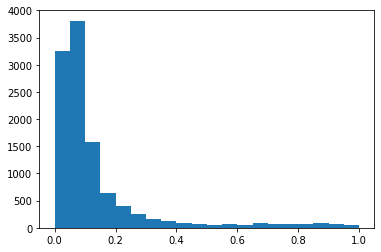

In [6]:
# Make a histogram of redshifts
q = "SELECT sn_z FROM mosthosts.mosthosts"
cursor.execute( q )
rows = cursor.fetchall()
zvals = np.array( [ row["sn_z"] for row in rows ] )
# fig,ax = pyplot.subplots()
pyplot.hist( zvals, range=(0,1), bins=20 )

In [7]:
# Associate the targetid from the public.secondary table.  There may be 
# clever way to do this all in SQL, but I'm banging it out in Python here.
# This is a little bit slow (but orders of magnitude faster than it was
# before I added the q3c index to public.secondary!).  It will update you
# every 1000 it completes; it takes 10-30 seconds to do each 1000.
cursor = dbconn.cursor()
q = "SELECT ra,dec,snname,sn_ra,sn_dec,sn_z,program,tns_name,iau_name,ptfiptf_name FROM mosthosts.mosthosts"
cursor.execute( q )
mosthosts = cursor.fetchall()
sys.stderr.write( f'Working on {len(mosthosts)} mosthosts...\n' )
radius = 1./3600.
nnone = 0
nmult = 0
none = 0
nmulttarget = 0
for i, row in enumerate(mosthosts):
    if (i%1000) == 0:
        sys.stderr.write( f"Did {i} of {len(mosthosts)}; nnone={nnone}, none={none}, nmult={nmult}, nmulttarget={nmulttarget}\n" ) 
    q = ( "SELECT ra,dec,targetid,program FROM public.secondary "
          "WHERE q3c_radial_query( ra, dec, %(ra)s, %(dec)s, %(radius)s ) "
          "   AND program='SN_HOSTS'" )
    # sys.stderr.write( f'Query: "{cursor.mogrify( q, { "ra": row["ra"], "dec": row["dec"], "radius": radius } )}"\n' )
    cursor.execute( q, { 'ra': row["ra"],
                         'dec': row['dec'],
                         'radius': radius } )
    matches = cursor.fetchall()
    if len(matches) == 0:
        for field in [ "targetid", "secondary_ra", "secondary_dec", "secondary_program" ]:
            row[field] = []
        nnone += 1
        sys.stderr.write( f'WARNING: {row["snname"]} had no entries in the secondary table\n' )
    else:
        if len(matches) > 1:
            # sys.stderr.write( f'{len(matches)} matches\n' )
            nmult += 1
        else:
            none += 1
        row["targetid"] = [ match["targetid"] for match in matches ]
        if len( set(row["targetid"]) ) > 1:
            nmulttarget += 1
        row["secondary_ra"] = [ match["ra"] for match in matches ]
        row["secondary_dec"] = [ match["dec"] for match in matches ]
        row["secondary_program"] = [ match["program"] for match in matches ]
print( f"{nnone} weren't found in the secondary table, {none} had one match, {nmult} had >1 match, {nmulttarget} had >1 targetid." )
        

Working on 20174 mosthosts...
Did 0 of 20174; nnone=0, none=0, nmult=0, nmulttarget=0
Did 1000 of 20174; nnone=0, none=0, nmult=1000, nmulttarget=96
Did 2000 of 20174; nnone=1, none=0, nmult=1999, nmulttarget=177
Did 3000 of 20174; nnone=1, none=0, nmult=2999, nmulttarget=276
Did 4000 of 20174; nnone=1, none=0, nmult=3999, nmulttarget=379
Did 5000 of 20174; nnone=1, none=0, nmult=4999, nmulttarget=491
Did 6000 of 20174; nnone=1, none=0, nmult=5999, nmulttarget=654
Did 7000 of 20174; nnone=1, none=0, nmult=6999, nmulttarget=820
Did 8000 of 20174; nnone=1, none=0, nmult=7999, nmulttarget=1000
Did 9000 of 20174; nnone=1, none=0, nmult=8999, nmulttarget=1145
Did 10000 of 20174; nnone=1, none=0, nmult=9999, nmulttarget=1276
Did 11000 of 20174; nnone=1, none=0, nmult=10999, nmulttarget=1374
Did 12000 of 20174; nnone=1, none=0, nmult=11999, nmulttarget=1457
Did 13000 of 20174; nnone=1, none=0, nmult=12999, nmulttarget=1562
Did 14000 of 20174; nnone=1, none=0, nmult=13999, nmulttarget=1607
Did

2 weren't found in the secondary table, 0 had one match, 20172 had >1 match, 2168 had >1 targetid.


In [18]:
# Use the targetids we determined to suck in the redshifts 
# of the hosts from everest.zpix_redshifts
#
# nhist is going to be a histogram of number of 
# redshifts found in everest.zpix_redshifts for each
# entry in the mosthosts table.
#
# REMEMBER that sometimes the same SN shows up more than
# once in the mosthosts table!  Will need to take this
# into account when doing statistics later.
#
# This one takes a few seconds per 1000.  (It was *much* slower
# without an index.  If you ever make a postgres database,
# having the right indexes is important for search time.
# Of course, adding more indexes slows down insert time....

cursor = dbconn.cursor()
nhist = np.zeros( 11, dtype=int )
for i, row in enumerate(mosthosts):
    if (i%1000 == 0):
        sys.stderr.write( f'Did {i} of {len(mosthosts)}; {i-nhist[0]:d} have at least 1 match\n' )
    if len( row['targetid'] ) == 0:
        sys.stderr.write( f"Skipping {row['snname']}, it has no target ids\n" )
        continue
    q = ( "SELECT z,zerr,zwarn,spectype,subtype FROM everest.zpix_redshifts "
          "WHERE targetid in %s" )
    cursor.execute( q, ( tuple(row['targetid']), ) )
    matches = cursor.fetchall()
    if len(matches) == 0:
        nhist[0] += 1
        for field in ( 'z', 'zerr', 'zwarn', 'spectype', 'subtype' ):
            row['field'] = []
    else:
        if len(matches) >= 10:
            nhist[10] += 1
        else:
            nhist[ len(matches) ] += 1
        row['z'] = [ m['z'] for m in matches ]
        row['zerr'] = [ m['zerr'] for m in matches ]
        row['zwarn'] = [ m['zwarn'] for m in matches ]
        row['spectype'] = [ m['spectype'] for m in matches ]
        row['subtype'] = [ m['subtype'] for m in matches ]
sys.stderr.flush()
for i,val in enumerate(nhist):
    if i == 10:
        print( f'{val:5d} have {i:2d}+ matches' )
    else:
        print( f'{val:5d} have {i:2d} matches' )

Did 0 of 20174; 0 have at least 1 match
Did 1000 of 20174; 47 have at least 1 match
Skipping ZTF19aapocyd, it has no target ids
Did 2000 of 20174; 115 have at least 1 match
Did 3000 of 20174; 149 have at least 1 match
Did 4000 of 20174; 190 have at least 1 match
Did 5000 of 20174; 241 have at least 1 match
Did 6000 of 20174; 298 have at least 1 match
Did 7000 of 20174; 356 have at least 1 match
Did 8000 of 20174; 407 have at least 1 match
Did 9000 of 20174; 463 have at least 1 match
Did 10000 of 20174; 502 have at least 1 match
Did 11000 of 20174; 532 have at least 1 match
Did 12000 of 20174; 582 have at least 1 match
Did 13000 of 20174; 641 have at least 1 match
Did 14000 of 20174; 689 have at least 1 match
Did 15000 of 20174; 754 have at least 1 match
Did 16000 of 20174; 836 have at least 1 match
Skipping ZTF19aaqdrtb, it has no target ids
Did 17000 of 20174; 899 have at least 1 match
Did 18000 of 20174; 945 have at least 1 match
Did 19000 of 20174; 997 have at least 1 match
Did 2000

19144 have  0 matches
  998 have  1 matches
   29 have  2 matches
    0 have  3 matches
    1 have  4 matches
    0 have  5 matches
    0 have  6 matches
    0 have  7 matches
    0 have  8 matches
    0 have  9 matches
    0 have 10+ matches


In [22]:
# Figure out how many *independent* supernovae have matches, and get their zs
SNeWithZ = {}
for row in mosthosts:
    if not 'z' in row:
        continue
    sn = row['snname']
    if len(row['z'])>0:
        if sn in SNeWithZ:
            SNeWithZ[sn]['z'].extend(row['z'])
            SNeWithZ[sn]['zerr'].extend(row['zerr'])
            SNeWithZ[sn]['zwarn'].extend(row['zwarn'])
            SNeWithZ[sn]['spectype'].extend(row['spectype'])
            SNeWithZ[sn]['subtype'].extend(row['subtype'])
        else:
            SNeWithZ[sn] = {}
            SNeWithZ[sn]['z'] = list(row['z'])
            SNeWithZ[sn]['zerr'] = list(row['zerr'])
            SNeWithZ[sn]['zwarn'] = list(row['zwarn'])
            SNeWithZ[sn]['spectype'] = list(row['spectype'])
            SNeWithZ[sn]['subtype'] = list(row['subtype'])
print( f'{len(SNeWithZ)} supernovae in the mosthosts lists have an everest redshift' )
# Turn the numerical values into numpy arrays for convenience
for sn,row in SNeWithZ.items():
    row['z'] = np.array(row['z'])
    row['zerr'] = np.array(row['zerr'])
    row['numz'] = row['z'].size
    row['meanz'] = row['z'].mean()
    row['stdz'] = np.std(row['z'])

988 supernovae in the mosthosts lists have an everest redshift


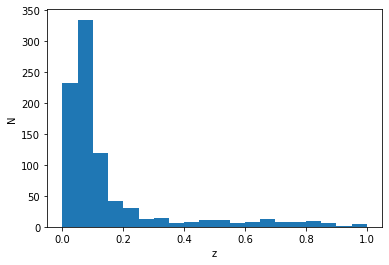

In [29]:
# Let's make a histogram of those zs
zvals = [ row['meanz'] for sn,row in SNeWithZ.items() ]
fig, ax = pyplot.subplots()
ax.hist( zvals, range=(0,1), bins=20)
ax.set_xlabel('z')
ax.set_ylabel('N')
fig.show()